I got some odd results with my VDF Emu. It was suggested I take a step back and look first at the dependence of HOD parameters. 

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [4]:
from pearce.mocks.kittens import TrainingBox
import numpy as np
from copy import deepcopy
from halotools.utils.table_utils import compute_conditional_percentiles
from halotools.mock_observables import get_haloprop_of_galaxies
from pearce.mocks.void_density_function import void_density_function
from matplotlib.colors import ListedColormap

In [5]:
boxno = 20

In [6]:
cat = TrainingBox(boxno, system = 'ki-ls')

In [7]:
cat.load(1.0, HOD='zheng07')

In [8]:
r_bins = np.logspace(-0.3, 2, 21)
rbins = r_bins
rbc = (r_bins[1:]+r_bins[:-1])/2.0

In [9]:
mass_bin_range = (12,16)
mass_bin_size = 0.1
mass_bins = np.logspace(mass_bin_range[0], mass_bin_range[1],
                           int((mass_bin_range[1] - mass_bin_range[0]) / mass_bin_size) + 1)
mass_bin_centers = (mass_bins[:-1] + mass_bins[1:]) / 2

In [28]:
def split_hod_vdf_plot(HOD, ab_params,sec_haloprop_key, n_splits = 2, cmap_name = 'BrBG'):
    cat.load_model(1.0, HOD=HOD, hod_kwargs= {'sec_haloprop_key': sec_haloprop_key})
    cat.model.param_dict['logMmin'] = 13.5
    cat.model.param_dict['logM0'] = 12.5
    
    cat.populate(ab_params, min_ptcl = 50)
    #print cat.model.param_dict
    catalog = cat.model.mock.galaxy_table
    sec_percentiles = compute_conditional_percentiles(prim_haloprop = cat.model.mock.halo_table['halo_mvir'],\
                                                  sec_haloprop = cat.model.mock.halo_table[sec_haloprop_key],
                                              prim_haloprop_bin_boundaries= mass_bins)
    
    sec_gal_percentiles = get_haloprop_of_galaxies(catalog['halo_id'], cat.model.mock.halo_table['halo_id'],
                                               sec_percentiles)
    
    # TODO bins here
    vdfs = np.zeros((n_splits, len(rbc)))
    perc_ranges = np.linspace(0,1, n_splits+1)
    
    #cmap = [ListedColormap(c) for c in sns.color_palette(cmap_name, n_splits)]
    cmap = sns.color_palette(cmap_name, n_splits)

    #cmap = sns.dark_palette(cmap_name, n_splits)
    #gal_pos = np.c_[[catalog[_c] for _c in ['x','y','z']]].T

    #base_vdf = void_density_function(gal_pos, rbins, n_ran=int(1e7), period = cat.Lbox, n_jobs = 4, PBC=True)
    #plt.plot(rbc, base_vdf, c = 'k', label = 'All')

    for i,c in enumerate(cmap):
        sec_bin_gals = np.logical_and(perc_ranges[i] < sec_gal_percentiles, sec_gal_percentiles<perc_ranges[i+1])
        
        gal_pos = np.c_[[catalog[sec_bin_gals][_c] for _c in ['x','y','z']]].T

        vdfs[i,:] = void_density_function(gal_pos, rbins, n_ran=int(1e7), period = cat.Lbox, n_jobs = 4, PBC=True)
        #print c
        plt.plot(rbc, vdfs[i], c = c, label = 'p < %0.2f'%perc_ranges[i+1])

    
    #gal_hist, _ = np.histogram(catalog['halo_mvir'], bins = mass_bins)
    #halo_hist, _= np.histogram(cat.model.mock.halo_table['halo_mvir'], bins = mass_bins)
    #full_hod = gal_hist*1.0/halo_hist
    
    
    #plt.plot(mass_bin_centers, full_hod, label = 'Full HOD', color = 'k')
    plt.legend(loc='best')
    plt.loglog();
    #plt.xscale('log')
    #plt.xlim(1e12,5e14)
    #plt.ylim([0, 40])
    plt.xlabel(r"$r$ [Mpc/h]")
    plt.ylabel(r"VDF")
    plt.title(sec_haloprop_key)
    plt.show()

In [40]:
ab_params = {'mean_occupation_centrals_assembias_corr1': 0.0,
             'mean_occupation_satellites_assembias_corr1': -1.0}

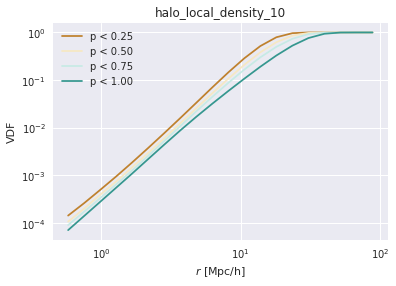

In [41]:
split_hod_vdf_plot('corrZheng07', ab_params, 'halo_local_density_10', n_splits = 4)

In [7]:
fiducial_hod = {'log_Mmin': 13.0, 'sigma_logM': 0.2, 'logM0': 12.5, 'logM1': 14.0, 'alpha': 1.05}

In [11]:
cat.populate(fiducial_hod)

/u/ki/swmclau2/.local/lib/python2.7/site-packages/halotools-0.7.dev5005-py2.7-linux-x86_64.egg/halotools/sim_manager/halo_table_cache_log_entry.py:404: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(self.fname)
/u/ki/swmclau2/.local/lib/python2.7/site-packages/halotools-0.7.dev5005-py2.7-linux-x86_64.egg/halotools/sim_manager/halo_table_cache_log_entry.py:221: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x

In [15]:
cat.calc_analytic_nd()

0.0009107828274244782

In [16]:
fiducial_vdf = cat.calc_vdf(r_bins, n_ran=100)

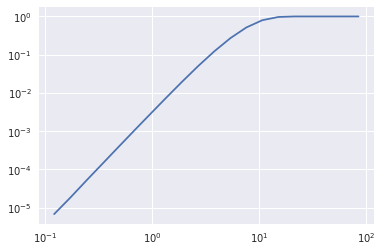

In [17]:
plt.plot(rbc, fiducial_vdf)
plt.loglog();

In [29]:
# measure shot noise
N = 10
vdfs = np.zeros((N, rbc.shape[0]))
for i in xrange(N):
    vdfs[i] = cat.calc_vdf(r_bins, n_ran =10)

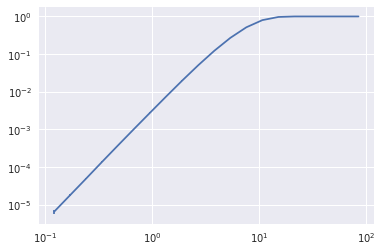

In [30]:
plt.errorbar(rbc, vdfs.mean(axis=0), yerr = vdfs.std(axis=0) )
plt.loglog();

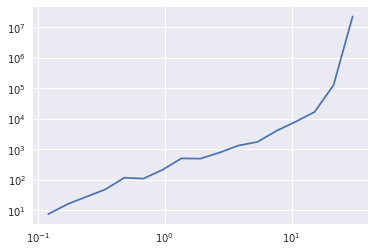

In [31]:
plt.plot(rbc, vdfs.mean(axis=0)/vdfs.std(axis=0))
plt.loglog();

In [32]:
#np.save('vdfs_nran100.npy', vdfs)
#np.save('vdfs_nran10.npy', vdfs)

In [38]:
varied_pname = 'alpha'
low, high = 0.8, 1.2 
N = 6
cmap = sns.cubehelix_palette(N, rot=-.4, as_cmap=False)
vals = np.linspace(low, high, N)

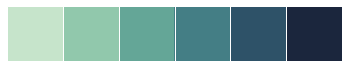

In [39]:
sns.palplot(cmap)

In [40]:
plot_vdfs = np.zeros((N, len(rbc)))
for i,(c,v) in enumerate(zip(cmap, vals)):
    print v
    params = deepcopy(fiducial_hod)
    params[varied_pname] = v
    cat.populate(params)
    plot_vdfs[i] = cat.calc_vdf(r_bins, n_ran=100)

0.8
0.88
0.96
1.04
1.12
1.2


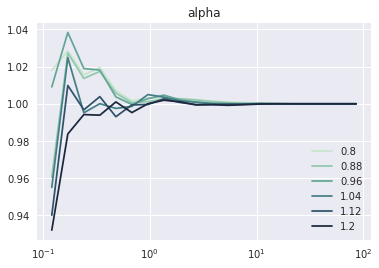

In [44]:
for c, pv, val in zip(cmap, plot_vdfs, vals):
    plt.plot(rbc, pv/fiducial_vdf, color = c, label=val)
    
plt.legend(loc='best')
plt.title(varied_pname)    
plt.xscale('log');